In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Using Random Forest to Classify SDSS DR18 objects

# The Sloan Digital Sky Survey (SDSS) and the DR18

The Sloan Digital Sky Survey (SDSS) stands as a pioneering astronomical endeavor aimed at unveiling the mysteries of the universe through systematic observation and analysis of celestial objects. Launched in 2000, SDSS sought to achieve a comprehensive understanding of cosmic structure and evolution by mapping and cataloging celestial objects on an unprecedented scale. Its primary objectives encompassed mapping large-scale cosmic structures, elucidating the nature of dark matter and dark energy, and providing a comprehensive spectroscopic database for a multitude of astronomical studies.

At the heart of the SDSS's success lies its advanced instrumentation. The survey employed a dedicated 2.5-meter telescope located at Apache Point Observatory in New Mexico. The focal plane of the telescope hosted a unique camera, equipped with 30 charged coupled devices (CCDs), enabling simultaneous imaging of a 3-degree wide region of the sky. This allowed SDSS to capture detailed images of billions of celestial objects, ranging from stars and galaxies to quasars.

SDSS was conducted in multiple phases, with each phase introducing technological advancements and expanded capabilities. The original SDSS-I, conducted from 2000 to 2005. From 2005 to 2008 we had the SDSS phase II and from 2008 to 2014 the SDSS-III. The SDSS-IV (2014–2020) extended the precision cosmological measurements to a critical early phase of cosmic history (eBOSS), expanding its infrared spectroscopic survey of the Galaxy in the northern and southern hemispheres (APOGEE-2), and for the first time using the Sloan spectrographs to make spatially resolved maps of individual galaxies (MaNGA).

Commencing its data collection for SDSS-V in October 2020, the Apache Point Observatory in New Mexico embarked on a transformative journey.They made a complete transition from plug plates, which employ manually positioned holes for starlight penetration, to cutting-edge small automated robot arms  called Focal Plane Systems (FPS). And early this year the SDSS-IV annouced their first data release.

Marking the initial data unveiling of the fifth phase of the Sloan Digital Sky Survey (SDSS-V), DR18 encompasses a comprehensive compilation of celestial information. A comprehensive breakdown of its contents can be found within the pages of the DR18 data release paper. [Almeida et al. (2023)](https://iopscience.iop.org/article/10.3847/1538-4365/acda98/pdf)

 ### DR18 includes the following:

- Targeting catalogs prepared for the Black Hole Mapper and Milky Way Mapper science programs, as well as for the open fiber programs
- Black Hole Mapper eFEDs spectra, part of the SPIDERS science program
- A Value Added Catalog of redshifts and classifications for all DR18 eFEDS targets

In this notebook we want to test our capabilities in using classification algorithms to distinguish between Galaxies and Quasars from the dataset. We're going to use python package [querySDSS](https://pypi.org/project/querySDSS/) which makes a specific SQL query to SDSS DR18 and returns a table with at least 2500 observations of 

- **Objid, Specobjid** - Object Identifiers
- **ra** - J2000 Right Ascension
- **dec** - J2000 Declination
- **redshift** - Final Redshift of the celestial object
- **u**, **g**, **r**, **i**, and **z** -  magnitude fit for u, g, r, i, and z. (they correspond to the five photometric bands: ultraviolet band, green band, red band, infrared band, and near infrared band respectively)
- **run** - Run number
- **rerun** - Rerun number
- **camcol** - Camera column
- **field** - Field number
- **redshift** - The redshift the obj sits
- **class** - The Obj class (Star, Galaxy, QSO)

In [22]:
from querySDSS.querySDSS.querySDSS import query_sdss_data

a = query_sdss_data(4000)
print(a)

       objid               ra        ... class     redshift  
------------------- ---------------- ... ------ -------------
1237645879551000764 348.841086940713 ... GALAXY     0.3996509
1237645879551066262 348.902530171573 ... GALAXY    0.03212454
1237645879562862699 15.8961264648656 ...   STAR -0.0008209134
1237645879562928144 16.0049119708675 ... GALAXY     0.3120482
1237645879562928258 16.0202444868512 ... GALAXY     0.2004682
1237645879562928805  16.026028703005 ... GALAXY     0.7526451
1237645879573873373 41.0196126806213 ... GALAXY     0.5046994
                ...              ... ...    ...           ...
1237646795989058131 118.949442944417 ...   STAR  3.937131e-05
1237646795989058308 118.848428413638 ...   STAR  0.0002519906
1237646795989058523 118.918747407749 ...   STAR  0.0001971318
1237646795989189134 119.246323384102 ...   STAR   0.000217692
1237646795989189214 119.230244179483 ...   STAR  3.716859e-05
1237646795989254419 119.332970787389 ...   STAR  0.0001484987
12376467

/home/isaac/Anaconda3/envs/COSMO/lib/python3.7/site-packages/astroquery/sdss/core.py:877: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


Now we see the table, but it is not a format we used to work with. Next step is to convert it to a more familiar format, a pandas.DataFrame, the type of the object is a astropy.table, it has a method called .to_pandas(), so we do it.

And we're going to work with a subset of columns, we wirte:

In [52]:
sdss_data = a[['ra', 'dec', 'u', 'g', 'r', 'i', 'z','redshift',  'class' ]]

In [53]:
sdss_data = sdss_data.to_pandas()
sdss_data

,ra,dec,u,g,r,i,z,redshift,class
0,348.841087,1.268802,25.92735,20.99570,19.24612,18.56461,18.43049,0.399651,b'GALAXY'
1,348.902530,1.271886,19.38905,18.24496,17.58728,17.20807,16.90905,0.032125,b'GALAXY'
2,15.896126,1.264845,20.14134,19.28787,19.04397,18.96897,18.79573,-0.000821,b'STAR'
3,16.004912,1.259423,21.50923,19.69340,18.47973,17.91998,17.55132,0.312048,b'GALAXY'
4,16.020244,1.267667,20.96947,20.29136,19.36779,18.86387,18.45551,0.200468,b'GALAXY'
...,...,...,...,...,...,...,...,...,...
3995,119.246323,-0.713899,21.16883,19.05197,18.22121,17.96988,17.95113,0.000218,b'STAR'
3996,119.230244,-0.879149,18.34543,16.51480,15.81666,15.58297,15.48080,0.000037,b'STAR'
3997,119.332971,-0.838072,20.69048,18.68261,17.88180,17.55374,17.40874,0.000148,b'STAR'
3998,119.367429,-0.769540,20.60680,18.71565,17.92311,17.60708,17.42728,0.000274,b'STAR'


Seems that the column "class" is written in bytecode, we need to transform it to strings.

In [54]:
sdss_data['class']

0       b'GALAXY'
1       b'GALAXY'
2         b'STAR'
3       b'GALAXY'
4       b'GALAXY'
          ...    
3995      b'STAR'
3996      b'STAR'
3997      b'STAR'
3998      b'STAR'
3999      b'STAR'
Name: class, Length: 4000, dtype: object

Let's see if there's any missing value:

In [55]:
missing_values = sdss_data.isna() 


any_missing = missing_values.any().any()


if any_missing:
    print("There are missing values in the DataFrame.")
else:
    print("No missing values found in the DataFrame.")

No missing values found in the DataFrame.


Nice, no missing values on our dataset.  We see we have a column with categorical data, the 'class' column in  which the objects belongs to. In total we have:


In [56]:
k = sdss_data.groupby(sdss_data['class']).size().reset_index(name='counts')
class_labels = k['class']
class_labels

0    b'GALAXY'
1       b'QSO'
2      b'STAR'
Name: class, dtype: object

We are inclined to question whether there is any way in which the numerical variables in this dataset are capable of aiding in the identification of the class, i.e. the identification of the categorical variable in the dataset. But before we're going to do a exploratory data analysis to see if there's any hint that it might be possible.

# EDA

As we want the algorithm to classify quasars and galaxies, we're going to explore the correlations first

In [28]:
from sklearn.preprocessing import LabelEncoder

sdss_data['class'] = LabelEncoder().fit_transform(sdss_data['class'])
corre_c_class = sdss_data.corrwith(sdss_data['class'])
correlation_matrix = sdss_data.corr()

The correlation matrix:

In [29]:
correlation_matrix

,ra,dec,u,g,r,i,z,redshift,class
ra,1.000000,-0.340108,-0.172559,-0.265076,-0.329298,0.018261,0.017848,-0.120259,0.518901
dec,-0.340108,1.000000,-0.003536,0.021184,0.030660,0.036738,0.036747,0.018180,-0.280516
u,-0.172559,-0.003536,1.000000,0.931351,0.831151,0.018210,0.017144,0.081903,-0.124727
g,-0.265076,0.021184,0.931351,1.000000,0.947446,0.003963,0.003045,0.141801,-0.177323
r,-0.329298,0.030660,0.831151,0.947446,1.000000,0.013112,0.012504,0.175634,-0.188468
i,0.018261,0.036738,0.018210,0.003963,0.013112,1.000000,0.999995,0.006825,-0.011943
z,0.017848,0.036747,0.017144,0.003045,0.012504,0.999995,1.000000,0.006953,-0.012137
redshift,-0.120259,0.018180,0.081903,0.141801,0.175634,0.006825,0.006953,1.000000,-0.277392
class,0.518901,-0.280516,-0.124727,-0.177323,-0.188468,-0.011943,-0.012137,-0.277392,1.000000


Let's plot a heatmap of the correlation matrix for a better understanding:

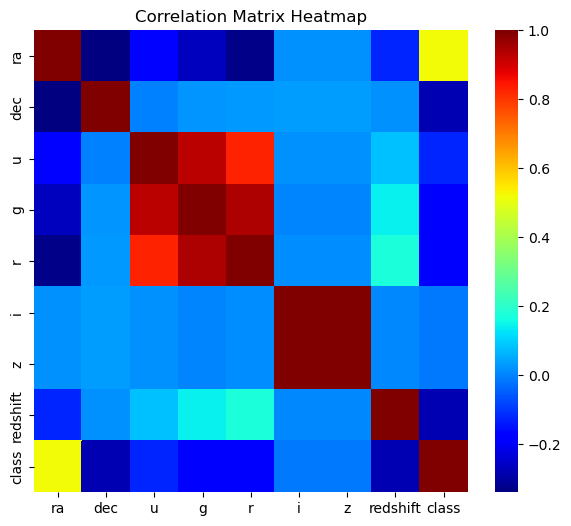

In [30]:
plt.figure(figsize=(7, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='jet')
plt.title('Correlation Matrix Heatmap')
plt.show()

We want to know how does theese variables are correlated with the Class (Quasars, Galaxies or Stars),

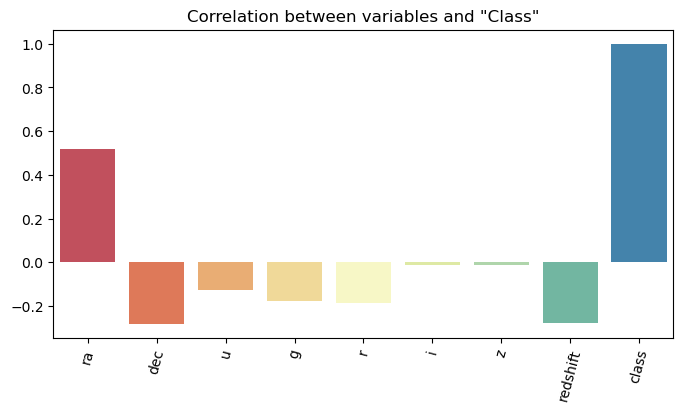

In [31]:
plt.figure(figsize=(8, 4))
sns.barplot(x=corre_c_class.index, y=corre_c_class.values, palette='Spectral')
plt.xticks(rotation=75)
plt.title('Correlation between variables and "Class"')
plt.show()

The photometric bands as well as the redshift have little correlation with the class, and extinction curves almost none. Unless we have a good argument to supose that the ascencion and declination (which will make up the coordinates in the sky of the object) are really numerical variables valid do distinguish between the classes, their correlation may be considered spurious.

We're going to use Random Forest as our classification algorithm. Spectroscopy data often contains complex relationships between different features (wavelengths, intensities, etc.). Random Forest can capture nonlinear and intricate interactions between these features, making it suitable for handling intricate spectral patterns that might not be well modeled by linear classifiers. Sometimes astronomical datasets can be imbalanced, where one class (e.g., quasars) is significantly less common than the other (e.g., stars). Random Forest can handle imbalanced data reasonably well, as it generates decision trees using bootstrapped samples, which can help mitigate the impact of class imbalance.

Also tree-based models are much more robust to outliers than linear models, and they do not need variables to be normalized to work. As such, we need to do very little preprocessing on our data.

# Random Forest

In a random forest classification, multiple decision trees are created using different random subsets of the data and features. Each decision tree is like an expert, providing its opinion on how to classify the data. Predictions are made by calculating the prediction for each decision tree, then taking the most popular result. 

We're going to use scikit-learn package for our Random Forest algorithm.

In [32]:
from sklearn.ensemble import RandomForestClassifier

Following the workflow, next we need to split our data. 

## Splitting the data:

When training any supervised learning model, it is important to split the data into training and test data. The training data is used to fit the model. The algorithm uses the training data to learn the relationship between the features and the target. The test data is used to evaluate the performance of the model.

The features of our model are all columns, except right ascension and declination.  So we have:

In [33]:
X = sdss_data.drop(['ra', 'dec', 'class'], axis=1)
y = sdss_data['class']

In [34]:
features  = X.columns.tolist()

And now, splitting

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Hyperparameter tunning

Next step is to optimize the hyperparameters that are going to be used in our model. To do that we're going to do a _random search_ in the parameter space. We define the hyperparameters to use and their ranges in a dictionary, called param_dist, that follows:

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = { 'n_estimators': randint(50,500), 
                             'max_depth': randint(1,20),
                             'min_samples_leaf':randint(1,20)}

In [37]:
RF_tunning = RandomForestClassifier()
RF_random_search = RandomizedSearchCV(RF_tunning, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5)

Fitting to the train data

In [38]:
RF_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff2bad3ab90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff2bad3add0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff2bad3aa90>})

Now we can retrive a dictionary of the best estimators we've got from our random search

In [39]:
best_estimators = RF_random_search.best_estimator_

In [40]:
best_params = {
    'n_estimators': best_estimators.n_estimators,
    'max_depth': best_estimators.max_depth,
    'min_samples_leaf': best_estimators.min_samples_leaf }

print('Best Hyperparameters:', best_params)

Best Hyperparameters: {'n_estimators': 285, 'max_depth': 15, 'min_samples_leaf': 1}


# Model fitting,  prediction and evaluation

Now we are in place to call our random forest classifier, 

In [41]:
Random_Forest = RandomForestClassifier(**best_params)

## Fitting the model

In [42]:
Random_Forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=285)

## Making prediction

In [43]:
y_pred = Random_Forest.predict(X_test)

## Evaluating

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Recall and Precision in Classification

**Recall (Sensitivity, True Positive Rate):**
Recall measures a model's ability to correctly identify instances of a specific class out of all instances that actually belong to that class. It calculates the proportion of true positives (correctly predicted positive instances) among all actual positive instances. Mathematically:

$$
 \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} 
$$

Where:
- True Positives (TP): Correctly predicted positive instances.
- False Negatives (FN): Instances that are positive but predicted as negative.

Higher recall indicates effective capture of instances in a class. It's crucial when missing positive instances has serious consequences, such as in medical diagnosis.

**Precision (Positive Predictive Value):**
Precision measures a model's ability to correctly identify instances of a specific class out of all instances predicted as belonging to that class. It calculates the proportion of true positives among all instances predicted as positive. Mathematically:

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} 
$$

Where:
- True Positives (TP): Same as before.
- False Positives (FP): Instances that are negative but predicted as positive.

Higher precision indicates accurate positive predictions. It's crucial when false positives are costly, as in spam email detection.

**Balancing Recall and Precision:**
Recall and precision are often inversely related. Balancing them depends on the application and the costs of false positives and false negatives. The F1-score, the harmonic mean of recall and precision, provides a single metric considering both:

$$
 F1\text{-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} 
$$

In summary, recall and precision offer different insights into model performance. The choice between them depends on the context and classification goals.

### Classification Report

In [46]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=['QSO', 'Galaxy', 'STAR']) 
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

         QSO       0.95      0.96      0.95       265
      Galaxy       0.99      0.82      0.90        80
        STAR       0.99      1.00      0.99       855

    accuracy                           0.98      1200
   macro avg       0.97      0.93      0.95      1200
weighted avg       0.98      0.98      0.98      1200



We can see that this result is quite similar (considering the size of the sample) to the one obtained by [A. O. Clarke 2020](https://arxiv.org/abs/1909.10963) 

### Performance metrics derived from applying the random forest model to the test dataset of 1.55 million spectroscopically confirmed sources. 

| Features                          | Precision - Galaxy | Precision - Quasar | Precision - Star | Recall - Galaxy | Recall - Quasar | Recall - Star | F1 Score - Galaxy | F1 Score - Quasar | F1 Score - Star |
| --------------------------------- | ------------------ | ------------------ | ---------------- | --------------- | --------------- | ------------- | ----------------- | ----------------- | --------------- |
| SDSS + WISE + resolved_r          | 0.987              | 0.961              | 0.991            | 0.995           | 0.944           | 0.965         | 0.991             | 0.952             | 0.978           |
| SDSS + WISE                       | 0.981              | 0.957              | 0.989            | 0.993           | 0.929           | 0.958         | 0.987             | 0.943             | 0.973           |
|**SDSS**                              | **0.956**              | **0.905**              | **0.958**            | **0.980**           | **0.865**           | **0.888**         | **0.968**             | **0.885**             | **0.922**           |
| SDSS + resolved_r                 | 0.981              | 0.948              | 0.979            | 0.993           | 0.924           | 0.945         | 0.987             | 0.936             | 0.962           |
| WISE                              | 0.880              | 0.886              | 0.711            | 0.954           | 0.862           | 0.466         | 0.915             | 0.874             | 0.563           |


* SDSS PSF magnitudes are in bands *u, g, r, i, z*, WISE magnitudes are in bands *w1, w2, w3, w4*.

### Confusion Matrix

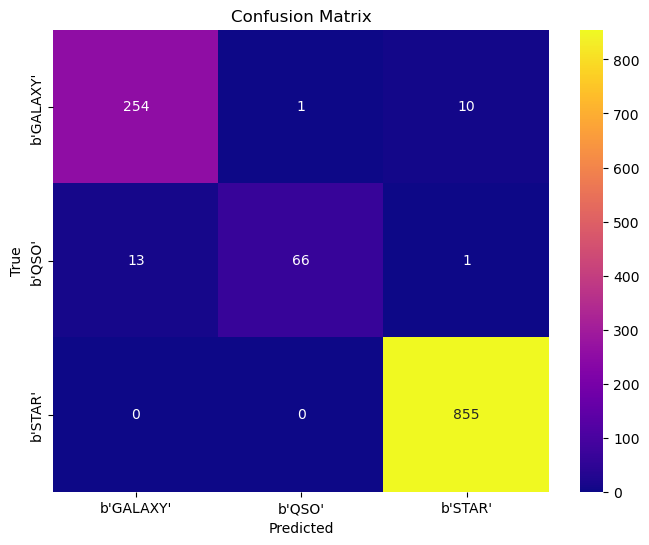

In [47]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, fmt='d', cmap='plasma', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Accuracy

Accuracy measures the proportion of correctly classified instances out of the total instances. It's a common metric for balanced datasets, but it might not be the best choice for highly imbalanced datasets.

In [48]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.98


#### Feature Importance

Our dataset is a bit inbalanced so we're going to use feature importance as a mean to evaluate our model.

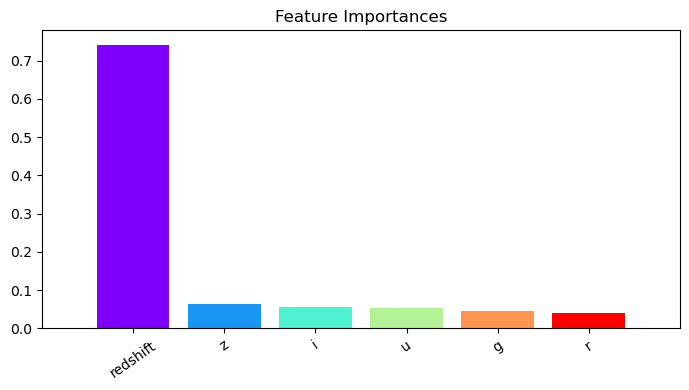

In [49]:
importances = Random_Forest.feature_importances_
indices = np.argsort(importances)[::-1]

num_bars = len(indices)
colors = plt.cm.rainbow(np.linspace(0, 1, num_bars))
# Plot the feature importances
plt.figure(figsize=(7, 4))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color=colors)
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=35) 
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Galaxies and quasars are both astronomical objects, but they have distinct differences in terms of their properties and behavior, but not in the spectrograph aspect. Most galaxies in the universe have relatively small redshift values. These values are typically in the range of 0 to 0.1, Quasars, on the other hand, are known for their extremely high redshift values. Quasars can have redshifts greater than 0.1 and even exceed values of 7 or more. This corresponds to the objects being billions of light-years away from us. The high redshift of quasars is a clear indicator of their extreme distance and their place in the early universe. 